In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_val_score, 
    GridSearchCV,
    StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    make_scorer,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef)

In [2]:
train_df = pd.read_csv('EN_combined_train_with_labels.csv.gz')
train_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,current_kurtosis,total_power,time_to_main_peak,time_to_peak,late_over_early,tdrift99,tfr,peak_count,gbn,bpr
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2299.0,-717094.898532,...,2.117825,1.709302e+09,85,85,0.987910,85.0,0.142357,3,1.198436,0.059642
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2446.0,-331957.541919,...,2.058622,2.991376e+08,87,87,0.988301,87.0,0.151160,3,1.381123,0.061975
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2262.0,-425532.152706,...,-0.067003,6.244385e+08,95,95,0.987491,95.0,0.142606,3,1.361857,0.050813
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2833.0,-306980.459766,...,2.443885,2.811583e+08,116,116,0.988450,116.0,0.133192,2,1.165654,0.062954
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2397.0,-362746.925366,...,-0.173890,3.885442e+08,94,94,0.988541,94.0,0.145504,7,1.390918,0.055013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2533.0,-278607.352936,...,2.026649,2.133856e+08,90,90,0.985736,90.0,0.151747,6,1.008092,0.062825
1039996,1039996_train_15,380.170340,True,True,True,True,949,3404.0,2426.0,-477777.966558,...,1.943512,6.842378e+08,82,82,0.987814,79.0,0.150305,3,1.245492,0.062706
1039997,1039997_train_15,370.109563,False,True,True,True,947,3409.0,2417.0,-466589.983952,...,1.601361,6.641180e+08,102,102,0.987833,102.0,0.142950,2,1.149456,0.062153
1039998,1039998_train_15,98.258524,True,True,True,False,921,3400.0,3799.0,-143212.214717,...,3.825219,4.630840e+07,92,92,0.989948,92.0,0.153135,5,1.192639,0.065264


# MODEL TRAINING

## Model Training - psd_label_high_avse

### Baseline Model - Logistic Regression

In [3]:
label_cols = [
    "psd_label_lq",
    "psd_label_high_avse",
    "psd_label_low_avse",
    "psd_label_dcr",
    "energy_label",
]

feature_cols = [col for col in train_df.columns if col not in label_cols + ['id']]

In [4]:
feature_cols

['tp0',
 'ED',
 'HWP',
 'LQ80',
 'PPR',
 'SC',
 'current_skewness',
 'spectral_centroid_power',
 'tail_charge_diff',
 'current_kurtosis',
 'total_power',
 'time_to_main_peak',
 'time_to_peak',
 'late_over_early',
 'tdrift99',
 'tfr',
 'peak_count',
 'gbn',
 'bpr']

In [5]:
pd.concat([train_df["psd_label_high_avse"].value_counts(), 
           train_df["psd_label_high_avse"].value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,1031559,0.991884
False,8441,0.008116


In [6]:
# DATA PREP
X = train_df[feature_cols]
y = train_df["psd_label_high_avse"]

In [7]:
# SPLIT
# We split first to protect the final test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)

In [8]:
# Baseline performance
pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

# Train
pipe_baseline.fit(X_train, y_train)

# Predict 
y_pred_baseline = pipe_baseline.predict(X_test)

              precision    recall  f1-score   support

       False       0.07      0.83      0.14      1688
        True       1.00      0.91      0.95    206312

    accuracy                           0.91    208000
   macro avg       0.54      0.87      0.55    208000
weighted avg       0.99      0.91      0.95    208000

AUC-PR Score: 0.2184
(Baseline/Random would be: 0.0081)
MCC Score: 0.2325


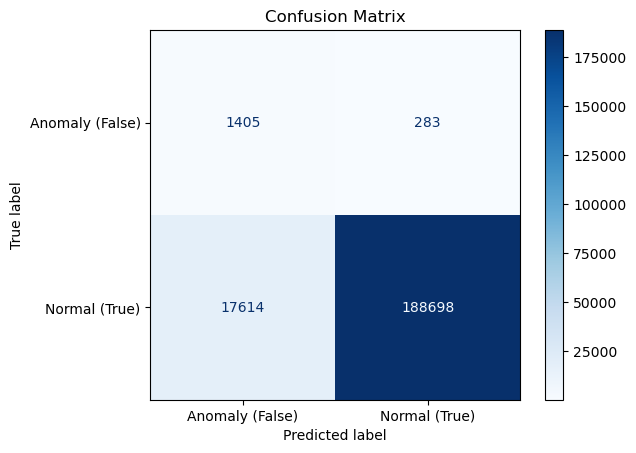

In [9]:
# Evaluate
print(classification_report(y_test, y_pred_baseline))

y_test_flipped = (~y_test)
# We need probabilities, not just predictions, for the curve
y_probs = pipe_baseline.predict_proba(X_test)[:, 0] # Prob of class 0 (False/Anomaly)

# Calculate AUC-PR
auc_pr = average_precision_score(y_test_flipped, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test_flipped.mean():.4f})")

mcc = matthews_corrcoef(y_test, y_pred_baseline)
print(f"MCC Score: {mcc:.4f}")

cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [10]:
# DEFINE THE PIPELINE (THE MODEL)
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="saga"
    ))
])

In [43]:
# HYPERPARAMETER TUNING (Find the Best Version)
# tune the 'lr' (Logistic Regression) part of the pipe
param_grid = {
    'lr__penalty': ['l1', 'l2'],    # Compare "feature selection" (l1) vs "shrinkage" (l2)
    'lr__class_weight': ['balanced', {0:1, 1:10}, {0:1, 1:100}],
    'lr__C': [0.1, 1, 10]   # Tune regularization strength
}

scoring_metrics = {
    'MCC': make_scorer(matthews_corrcoef),
    'False_F1': make_scorer(f1_score, pos_label=False),
    'True_F1': make_scorer(f1_score, pos_label=True),
    'AUC_PR': make_scorer(average_precision_score, needs_proba=True, pos_label=False)
}
scorer = make_scorer(f1_score, pos_label=False)

# Use Standard Stratified K-Fold for speed during the search
grid = GridSearchCV(
    estimator=pipe,        # pass the pipe here
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5), 
    scoring=scoring_metrics,
    refit='AUC_PR',
    n_jobs=-1,
    verbose=3
)

print("Tuning hyperparameters...")
grid.fit(X_train, y_train) # runs the internal CV loops

Tuning hyperparameters...
Fitting 5 folds for each of 18 candidates, totalling 90 fits



KeyboardInterrupt



In [10]:
# RESULTS VISUALIZATION
# Convert the results dictionary to a DataFrame
cv_results = grid.cv_results_
results_df = pd.DataFrame(cv_results)

# Filter for the columns we want to see
columns_to_keep = [
    "params", 
    "mean_test_score", 
    "std_test_score", 
    "rank_test_score",
    "split0_test_score", 
    "split1_test_score", 
    "split2_test_score", 
    "split3_test_score", 
    "split4_test_score"
]

# Create a clean view sorted by best performance
clean_results = results_df[columns_to_keep].sort_values(by="rank_test_score")

# Display the top 10 rows
pd.set_option('display.max_colwidth', None) # Show full param dict

clean_results

,params,mean_test_score,std_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
2,"{'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 10}, 'lr__penalty': 'l1'}",0.996026,0.000019,1,0.996008,0.996002,0.996041,0.996050,0.996032
8,"{'lr__C': 1, 'lr__class_weight': {0: 1, 1: 10}, 'lr__penalty': 'l1'}",0.996026,0.000019,2,0.996008,0.995999,0.996041,0.996050,0.996032
3,"{'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 10}, 'lr__penalty': 'l2'}",0.996025,0.000020,3,0.996005,0.995999,0.996041,0.996050,0.996032
9,"{'lr__C': 1, 'lr__class_weight': {0: 1, 1: 10}, 'lr__penalty': 'l2'}",0.996025,0.000019,4,0.996008,0.995999,0.996038,0.996050,0.996032
15,"{'lr__C': 10, 'lr__class_weight': {0: 1, 1: 10}, 'lr__penalty': 'l2'}",0.996025,0.000019,4,0.996008,0.995999,0.996038,0.996050,0.996032
14,"{'lr__C': 10, 'lr__class_weight': {0: 1, 1: 10}, 'lr__penalty': 'l1'}",0.996025,0.000019,4,0.996008,0.995999,0.996038,0.996050,0.996032
5,"{'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 100}, 'lr__penalty': 'l2'}",0.995931,0.000003,7,0.995930,0.995936,0.995933,0.995927,0.995930
4,"{'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 100}, 'lr__penalty': 'l1'}",0.995931,0.000003,7,0.995930,0.995936,0.995933,0.995927,0.995930
11,"{'lr__C': 1, 'lr__class_weight': {0: 1, 1: 100}, 'lr__penalty': 'l2'}",0.995931,0.000003,7,0.995930,0.995936,0.995933,0.995927,0.995930
10,"{'lr__C': 1, 'lr__class_weight': {0: 1, 1: 100}, 'lr__penalty': 'l1'}",0.995931,0.000003,7,0.995930,0.995936,0.995933,0.995927,0.995930


Best Params found: {'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 10}, 'lr__penalty': 'l1'}

--- FULL FEATURE RANKING ---
                    Feature  Coefficient
9          current_kurtosis     0.657700
2                       HWP    -0.427221
10              total_power    -0.266523
12             time_to_peak    -0.224676
6          current_skewness    -0.155673
5                        SC    -0.123714
18                      bpr     0.070765
0                       tp0    -0.063277
4                       PPR    -0.056799
15                      tfr    -0.052308
1                        ED     0.046171
16               peak_count    -0.042127
17                      gbn     0.037496
11        time_to_main_peak     0.029955
8          tail_charge_diff    -0.012916
13          late_over_early    -0.006865
14                 tdrift99    -0.006699
7   spectral_centroid_power    -0.004253
3                      LQ80     0.000000


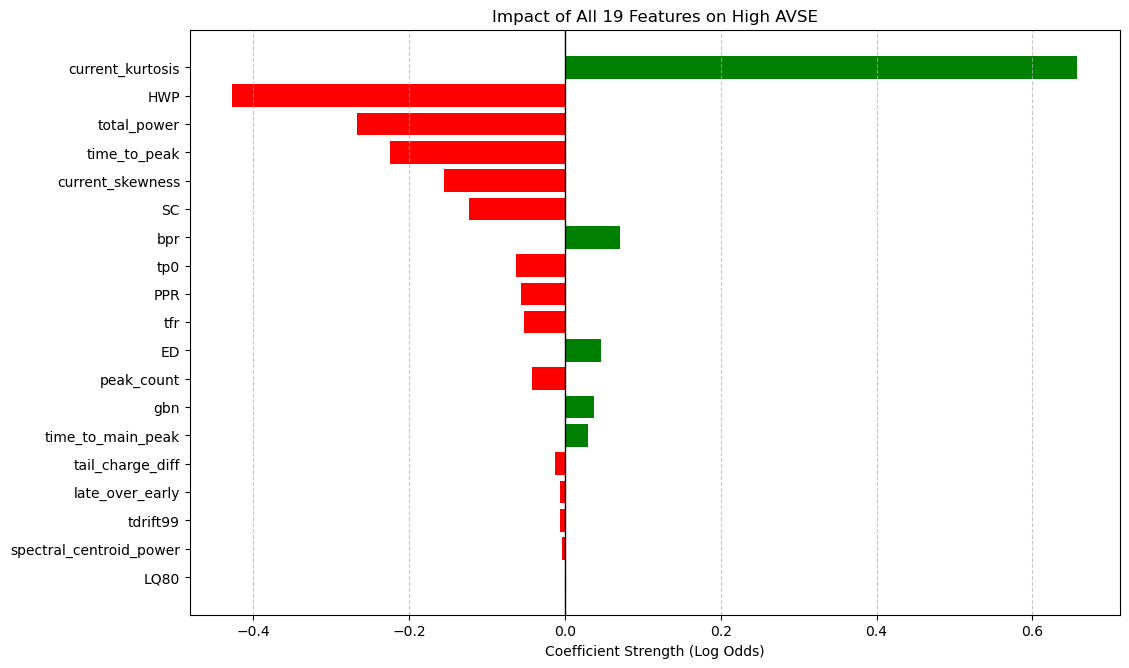

In [14]:
# Get the best model
best_model = grid.best_estimator_
print(f"Best Params found: {grid.best_params_}")

# Extract the Logistic Regression step and its coefficients
coefficients = best_model.named_steps['lr'].coef_[0]

# Create df
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Importance': abs(coefficients)
})

# Sort by Absolute Importance (biggest impact at the top)
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# REPORTING (TEXT)
# Use an option context to force Pandas to print the WHOLE list, not just top/bottom
print("\n--- FULL FEATURE RANKING ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance[['Feature', 'Coefficient']])


# VISUALIZATION (PLOT ALL)

# Calculate a dynamic height: 0.4 inches per feature ensures labels are readable
num_features = len(feature_importance)
plot_height = max(6, num_features * 0.4) 

plt.figure(figsize=(12, plot_height))

# Create the colors list based on positive/negative
colors = feature_importance['Coefficient'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot Horizontal Bar Chart
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)

# Aesthetics
plt.xlabel("Coefficient Strength (Log Odds)")
plt.title(f"Impact of All {num_features} Features on High AVSE")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1) # The zero line
plt.grid(axis='x', linestyle='--', alpha=0.7) # Grid lines help read values

# Put the most important features at the top (invert Y axis)
plt.gca().invert_yaxis() 

plt.show()

In [20]:
best_idx = grid.best_index_

print(f"Internal CV Performance for the Best Model")
print(f"Mean F1-Score: {grid.best_score_}")
print(f"Std Dev:    {cv_results['std_test_score'][best_idx]:.4f}")

print("\nBreakdown by Fold - Best Model")
for i in range(5):
    # This pulls the specific score for this model on Fold 1, Fold 2, etc.
    score = cv_results[f'split{i}_test_score'][best_idx]
    print(f"Fold {i+1}: {score}")

Internal CV Performance for the Best Model
Mean F1-Score: 0.9960264971881567
Std Dev:    0.0000

Breakdown by Fold - Best Model
Fold 1: 0.9960079539179685
Fold 2: 0.9960019914608572
Fold 3: 0.9960407990826242
Fold 4: 0.9960499355738155
Fold 5: 0.9960318059055178


In [19]:
# EVALUATION
print("\nFinal Test Set Performance (20% Hold-out):")
y_pred = best_model.predict(X_test)
print("F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Final Test Set Performance (20% Hold-out):
F1: 0.9959662916194941
              precision    recall  f1-score   support

       False       0.66      0.02      0.04      1688
        True       0.99      1.00      1.00    206312

    accuracy                           0.99    208000
   macro avg       0.83      0.51      0.52    208000
weighted avg       0.99      0.99      0.99    208000

